# Domino

El domino es un puzzle lógico en el que hay que colocar piezas de domino sobre una matriz de números, tapando cada número una vez y usando cada dominó una sóla vez.

    Tile the rectangle with dominoes (1×2 rectangles) so that every possible domino appears exactly once (that is, every possible pair of numbers, including doubles).
    
Domino online (hay otras páginas pero por favor usad ésta)

https://www.chiark.greenend.org.uk/~sgtatham/puzzles/js/dominosa.html

Instrucciones

https://www.chiark.greenend.org.uk/~sgtatham/puzzles/doc/dominosa.html#dominosa


### Datos iniciales

El domino está relleno por completo de números, y nosotros tenemos que unir parejas de dominos adyacentes horizontal o verticalmente.

In [1]:
import numpy as np

In [2]:
DOMINO6 = np.array([
    [3,1,5,4,6,1,4,2],
    [3,6,5,0,0,0,5,2],
    [5,3,1,5,5,2,4,2],
    [5,1,0,6,6,2,3,1],
    [6,0,2,3,6,3,5,0],
    [6,3,4,4,0,4,4,2],
    [1,6,1,1,0,3,2,4],
])
DOMINO6_BIS = np.array([
    [2,2,0,4,4,4,6,6],
    [3,5,4,1,1,6,4,5],
    [4,6,2,1,6,0,3,0],
    [0,5,5,5,5,2,1,2],
    [3,4,1,5,3,3,2,1],
    [0,3,2,2,6,1,1,0],
    [0,5,4,3,3,0,6,6],
])


In [3]:
print(DOMINO6)

[[3 1 5 4 6 1 4 2]
 [3 6 5 0 0 0 5 2]
 [5 3 1 5 5 2 4 2]
 [5 1 0 6 6 2 3 1]
 [6 0 2 3 6 3 5 0]
 [6 3 4 4 0 4 4 2]
 [1 6 1 1 0 3 2 4]]


## Plantear el problema

#### Elegimos las variables

Usamos **variables binarias** `f[j,k]` y `c[j,k]`, que se interpretan de esta forma:

- `f[j,k] = 1` si hay un domino que ocupa las posiciones (j,k) y (j,k+1).
- `c[j,k] = 1` si hay un domino que ocupa las posiciones (j,k) y (j+1,k).

Para trabajar con estas variables lo primero que tenemos que hacer es asegurarnos de que una misma casilla no puede estar ocupada por más de un domino. Para esto tenemos que sumar las variables adyacentes.

Dependiendo de si la casilla están en la primera o última fila, y en la primera o última columna, tenemos que sumar distintas variables. 
Por ejemplo, sólo hay dos posibles dominos que podemos colocar sobre la casilla 0,0
```python
    f[0,0] + c[0,0] == 1
```
Pero hay cuatro posibles dominos que podemos colocar sobre la casilla 1,1
```python
    f[1,0] + c[0,1] + f[1,1] +  c[1,1] == 1
```
Además, tenemos que imponer que solo colocamos cada pieza de domino una vez.

In [6]:
def DOMINO(data):
    nrows, ncols = data.shape
    N = data.max()
    p = MixedIntegerLinearProgram(maximization=True, solver = "GLPK")
    #Se pueden usar otras librerías para hacer los cálculos:
    #Esto es habitual: se define el problema MILP en una librería (el "modelling language")
    #y se resuelve con otra librería (el "solver")
#    p = MixedIntegerLinearProgram(maximization=True, solver = "Coin")
    
    #c[j,k] = 1 si hay un imán entre  j,k
    #c[j,k] = 0 si no hay un imán en la posicion j,k
    c = p.new_variable(binary=True)
    f = p.new_variable(binary=True)
    
    #Cada numero en un solo domino
    for j in range(nrows):
        for k in range(ncols):
            vs = []
            if k>0: vs.append(f[j,k-1])
            if k<ncols: vs.append(f[j,k])
            if j>0: vs.append(c[j-1,k])
            if j<nrows: vs.append(c[j,k])
            p.add_constraint(sum(vs) == 1)

    #Cada domino una sola vez
    for j in range(N+1):
        for k in range(j+1):
            print (k,j)
            vs = sum(f[n,m] for n in range(nrows) for m in range(ncols-1)
                            if sorted((data[n,m], data[n,m+1]))==[k,j]
                    )
            vs += sum(c[n,m] for n in range(nrows-1) for m in range(ncols)
                            if sorted((data[n,m], data[n+1,m]))==[k,j]
                    )
            print(vs==1)
            p.add_constraint(vs == 1)

    #La función objetivo no es importante, porque cualquier punto en la región factible
    #es una solución válida del sudoku
    #(si el puzzle viene de la web de Simon Tatham, la solucion es unica).
    p.set_objective(1)
    return c,f,p

In [7]:
def muestra_DOMINO(data,c,f,p):
    nrows, ncols = data.shape
    df, dc = p.get_values(f), p.get_values(c)
    (sum((text(str(data[j,k]),
               (k,-j),
               fontsize=30) 
          for j in range(nrows) for k in range(ncols))) + 
     sum(line2d([(k,-j), (k+1,-j)],
                color='green')
         for j in range(nrows) for k in range(ncols-1)
         if df[j,k]) + 
     sum(line2d([(k,-j), (k,-j-1)],
                color='green')
         for j in range(nrows-1) for k in range(ncols)
         if dc[j,k])
    ).show(axes=False, figsize=6)

In [8]:
c,f,p = DOMINO(DOMINO6)

0 0
x_22 + x_24 + x_89 == 1
0 1
x_11 + x_37 + x_50 + x_51 + x_63 + x_102 == 1
1 1
x_100 == 1
0 2
x_27 + x_53 + x_66 + x_79 == 1
1 2
x_47 == 1
2 2
x_15 + x_31 + x_43 == 1
0 3
x_67 + x_104 == 1
1 3
x_0 + x_34 + x_35 + x_60 == 1
2 3
x_58 + x_59 + x_68 + x_106 == 1
3 3
x_1 == 1
0 4
x_7 + x_86 + x_88 == 1
1 4
x_10 + x_85 + x_87 == 1
2 4
x_12 + x_42 + x_44 + x_69 + x_92 + x_93 + x_95 + x_108 == 1
3 4
x_45 + x_71 + x_75 + x_82 + x_91 == 1
4 4
x_84 + x_90 == 1
0 5
x_20 + x_23 + x_25 + x_26 + x_76 == 1
1 5
x_2 + x_21 + x_36 + x_48 == 1
2 5
x_28 + x_40 == 1
3 5
x_17 + x_32 + x_61 + x_74 == 1
4 5
x_4 + x_13 + x_29 + x_77 == 1
5 5
x_5 + x_33 + x_38 == 1
0 6
x_9 + x_52 + x_64 + x_73 == 1
1 6
x_3 + x_8 + x_81 + x_96 + x_98 == 1
2 6
x_56 == 1
3 6
x_16 + x_19 + x_55 + x_70 + x_72 + x_80 + x_83 == 1
4 6
x_6 == 1
5 6
x_18 + x_39 + x_41 + x_49 == 1
6 6
x_54 + x_57 + x_65 == 1


In [9]:
p.solve()

1.0

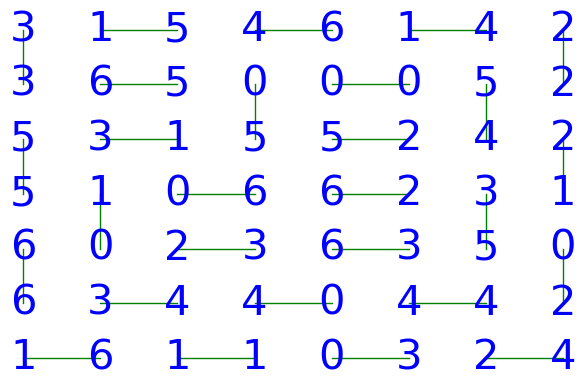

In [10]:
muestra_DOMINO(DOMINO6,c,f,p)